Nimai Mahajan | 2/13/22

In [1]:
# IMPORTS

In [2]:
# Import core libraries
import re
import string
import numpy as np
import pandas as pd

In [3]:
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

In [4]:
# Import NLTK/training libraries
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_curve, auc, accuracy_score

# Import some images from the web
from IPython.display import Image
from IPython.core.display import HTML

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nimai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nimai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# EDA

In [6]:
# Read CSV
df = pd.read_csv("airline_tweets.csv")

In [7]:
# Check size of data set
df.shape

(14640, 15)

In [8]:
# See how it looks
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
# Get some information about the data (columns, non-null count, etc.)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [10]:
# Calculate percentage of missing info for each column of df
def percent_missing(df):
    percent_nan = 100 * df.isnull().sum() / len(df)
    percent_nan = percent_nan[percent_nan > 0]
    return percent_nan.sort_values(ascending=False)

In [11]:
percent_missing(df)

negativereason_gold          99.781421
airline_sentiment_gold       99.726776
tweet_coord                  93.039617
negativereason               37.308743
user_timezone                32.923497
tweet_location               32.329235
negativereason_confidence    28.128415
dtype: float64

In [12]:
# We can explore the columns with missing info, but we are only really concerned with 'airline_sentiment' and 'text'

In [13]:
print("Null values:")
print(df[['airline_sentiment', 'text']].isnull().sum()) # Good to go!
print("Count of airline_sentiment values:")
print(df['airline_sentiment'].value_counts())

Null values:
airline_sentiment    0
text                 0
dtype: int64
Count of airline_sentiment values:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


<AxesSubplot:ylabel='airline'>

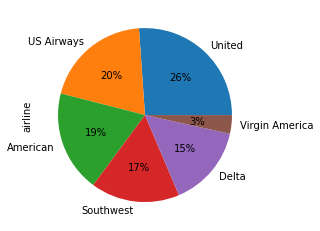

In [14]:
df['airline'].value_counts().plot(kind='pie', autopct='%1.0f%%')

In [15]:
df.groupby(['airline','airline_sentiment'])['text'].count().unstack(level=1)

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


<AxesSubplot:xlabel='airline', ylabel='count'>

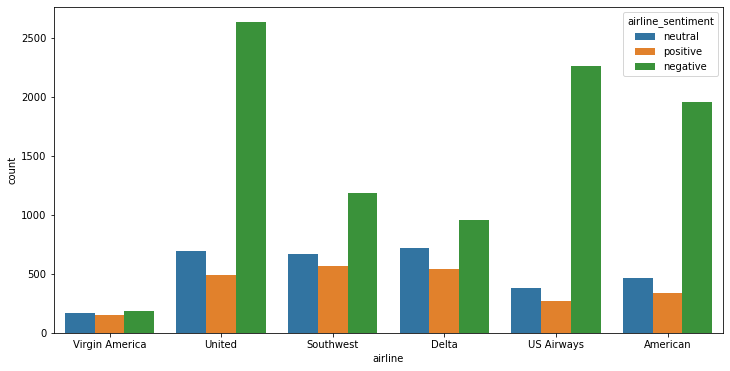

In [16]:
# Let's visualize this very important query

plt.figure(figsize=(12,6))
sns.countplot(data=df,x='airline',hue='airline_sentiment')

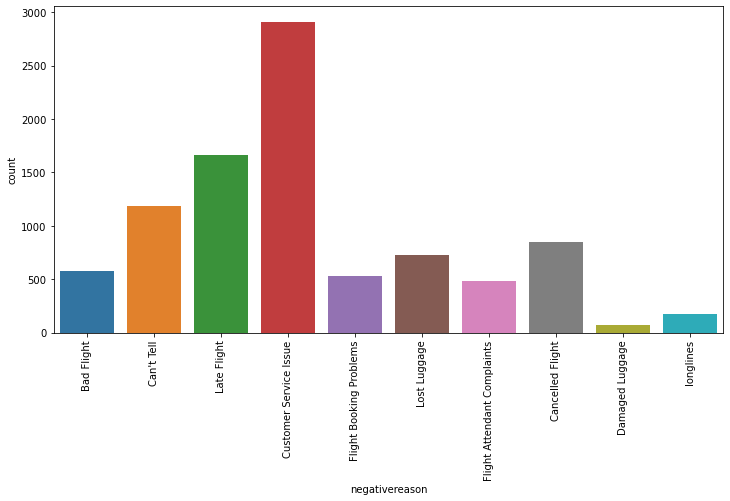

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(data=df,x='negativereason')
plt.xticks(rotation=90);

In [18]:
Image(url='https://www.oreilly.com/library/view/machine-learning-with/9781789346565/assets/e322457d-6d42-4f82-999a-a2a446d5862e.png')

In [19]:
# DATA CLEANING

In [20]:
# Define preprocessing functions

# This compiles a regex object based on unicodes for all possible emojis
def remove_emojis(text): # from https://stackoverflow.com/a/58356570
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    
    text = re.sub(emoj, '', text)
    text = re.sub(r'[:;=8$-][^\s]+','', text) # remove emojis like :D or 8) or -_-
    
    return text

# This filters the text by going through stopwords and lemmatizer
def filter_and_lemmatize(text, lemmatize=False):
    tokens = []
    stop_words = set(stopwords.words('english'))
    excluded_puncs = set(string.punctuation)
    word_lemmatizer = WordNetLemmatizer()
    
    for token in text.split():
        if (len(token) > 1) and (token not in stop_words):
            token = ''.join(ch for ch in token if ch not in excluded_puncs) # remove punctuations
            if lemmatize:
                tokens.append(word_lemmatizer.lemmatize(token))
            else:
                tokens.append(token)
                
    return ' '.join(tokens)

# This runs all the regexes on the data to remove all extraneous characters
def regex_clean(text):
    text = re.sub(r'http\S+', '', text)  # remove URls (i.e. http://somewebsite.com)
    text = re.sub(r'&amp;', '', text)    # remove literal ampersand (&amp;)
    text = re.sub(r'@[^\s]+','', text)   # remove words with users/mentions (i.e. @VirginAirlines)
    text = re.sub(r'\w*\d\w*', '', text) # remove words containing numbers (i.e. 123abc, abc123, 123abc123)

    return text
    
# Main function to preprocess text data
def preprocess_main(text):
    text = text.lower().strip() # strip whitespace and turn text into lowercase
    text = remove_emojis(text) # remove emojis / smileys
    text = regex_clean(text)
    text = filter_and_lemmatize(text, lemmatize=True)

    return text
    

In [21]:
#df['text_cleaned'] = df.apply(lambda x: preprocess_main(x['text']), axis=1)
df['text_cleaned'] = np.vectorize(preprocess_main)(df['text'])

In [22]:
# Check some filtered text (print it this way since any other way cuts off the text)
for i in range(0,10):
    print("-- ORIGINAL --:", df["text"].iloc[i])
    print("-- CLEANED --:",  df["text_cleaned"].iloc[i])

-- ORIGINAL --: @VirginAmerica What @dhepburn said.
-- CLEANED --: said
-- ORIGINAL --: @VirginAmerica plus you've added commercials to the experience... tacky.
-- CLEANED --: plus added commercial experience tacky
-- ORIGINAL --: @VirginAmerica I didn't today... Must mean I need to take another trip!
-- CLEANED --: today must mean need take another trip
-- ORIGINAL --: @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
-- CLEANED --: really aggressive blast obnoxious entertainment guest face little recourse
-- ORIGINAL --: @VirginAmerica and it's a really big bad thing about it
-- CLEANED --: really big bad thing
-- ORIGINAL --: @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA
-- CLEANED --: seriously would pay flight seat playing really bad thing flying va
-- ORIGINAL --: @VirginAmerica yes, nearly every time I fly VX this 

In [23]:
# Let's calculate word counts to see how much we saved in preprocessing
wc_orig    = df.text.str.split().str.len().sum()
wc_cleaned = df.text_cleaned.str.split().str.len().sum()
(wc_cleaned / wc_orig) * 100

50.564914914527606

In [24]:
# 50% !

In [25]:
# Let's visualize the most used words for both positive and negative tweets

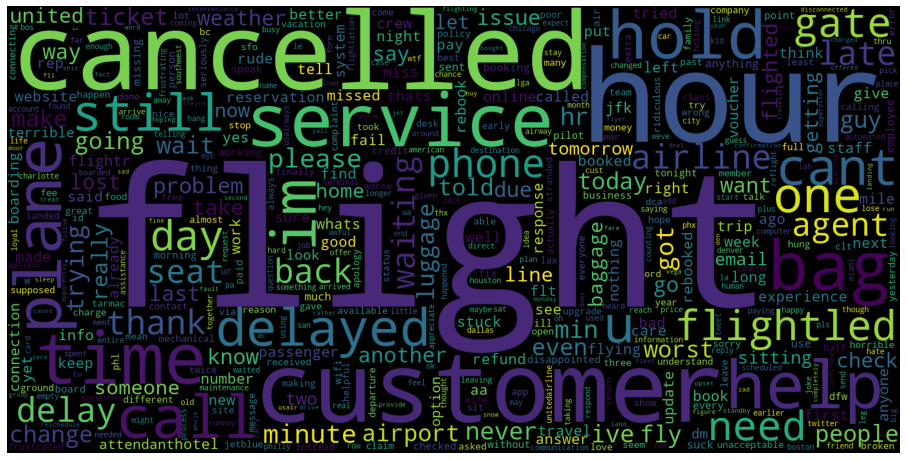

In [26]:
data_neg = df[df['airline_sentiment']=='negative']
words = ' '.join(data_neg['text_cleaned'])
plt.figure(figsize=(16,16))
wc = WordCloud(max_words=500, width=1600, height=800, collocations=False).generate(words)
plt.axis('off')
plt.imshow(wc)

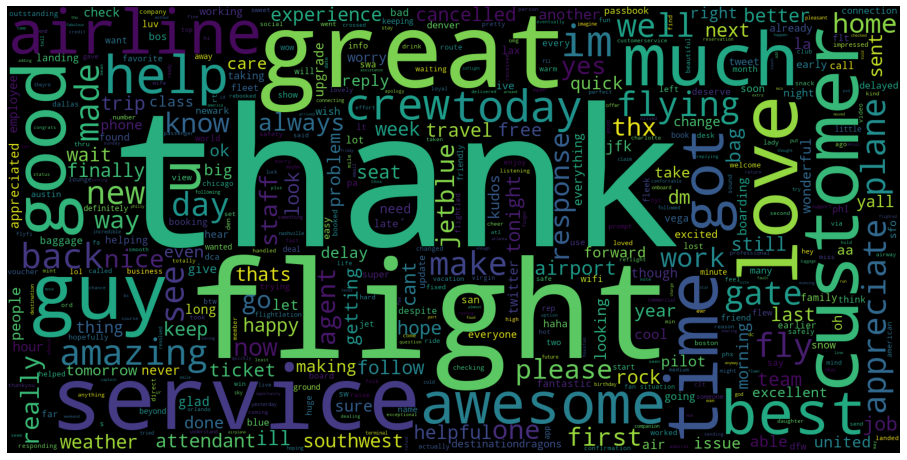

In [27]:
data_pos = df[df['airline_sentiment']=='positive']
words = ' '.join(data_pos['text_cleaned'])
plt.figure(figsize=(16,16))
wc = WordCloud(max_words=500, width=1600, height=800, collocations=False).generate(words)
plt.axis('off')
plt.imshow(wc)

In [28]:
# Encode feature column into TD-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text_cleaned'])
print(f"'text' feature transformed into {len(vectorizer.get_feature_names())} features")

'text' feature transformed into 10633 features


In [29]:
# Encode categorical labels into numerical values (skip, doesn't look like this is necessary)
encoder = LabelEncoder()
df['airline_sentiment_encoded'] = encoder.fit_transform(df['airline_sentiment'])
#0: negative, 1: neutral, 2: positive
y = df['airline_sentiment']

In [30]:
# Split train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

In [31]:
X_train.shape

(13176, 10633)

In [32]:
X_test.shape

(1464, 10633)

In [33]:
# Initialize model and fit to training data
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [34]:
model.coef_

array([[ 0.09695077,  0.        ,  0.04246969, ...,  0.01771312,
         0.        ,  0.28330728],
       [ 0.03755126,  0.        , -0.00874135, ..., -0.01517322,
         0.        , -0.09458596],
       [-0.13450204,  0.        , -0.03372835, ..., -0.00253991,
         0.        , -0.18872132]])

In [35]:
# Get predictions on test data
y_pred = model.predict(X_test)

In [36]:
# Get probabilities from log odds
y_pred_prob = model.predict_proba(X_test)

In [52]:
# Let's merge predictions and probabilities back into the original dataframe at the appropriate indexes
# This makes it easy to visualize

y_test_df = pd.DataFrame(data=y_test)
y_test_df['prediction'] = y_pred
y_test_df['negative_prob'] = y_pred_prob[:,0]
y_test_df['neutral_prob'] = y_pred_prob[:,1]
y_test_df['positive_prob']  = y_pred_prob[:,2]

df_merged = pd.merge(df,y_test_df.drop('airline_sentiment', axis=1),how = 'left',left_index = True, right_index = True)
df_with_results = df_merged[~df_merged['prediction'].isna()]
df_with_results[['text_cleaned','airline_sentiment','prediction','negative_prob','neutral_prob','positive_prob']].sample(20).sort_index()

,text_cleaned,airline_sentiment,prediction,negative_prob,neutral_prob,positive_prob
221,looking forward first flight today cancelled f...,negative,negative,0.631908,0.243137,0.124954
254,thanks good time back vodkatonics entire fligh...,positive,positive,0.266702,0.161811,0.571488
892,whats good number call speak someone fix peopl...,negative,negative,0.922315,0.050275,0.027410
1335,literally suck,negative,negative,0.891956,0.066644,0.041401
3081,send jeff smisek trip jetblue sw make sure tak...,negative,negative,0.544735,0.222657,0.232608
3143,thanks formed submitted im betting someone wou...,negative,negative,0.422436,0.333510,0.244054
3484,spends minute beating lady bag fee random stra...,negative,negative,0.733262,0.205584,0.061155
3584,im pretty sure ive got shin split sprinting ia...,negative,negative,0.694908,0.163412,0.141680
3813,pnr numbered flight first leg cancelled flight...,negative,negative,0.831236,0.122889,0.045876
3829,thank you one month ago none now weird club on...,positive,neutral,0.224152,0.410976,0.364872


In [38]:
# EVALUATE MODEL
# Run metrics to compare predictions to actual results (y_pred vs y_test)

In [39]:
print(classification_report(y_test,y_pred))

# Precision: When it predicts negative tweet, it is correct 82% of the time
# Recall: It correctly identifies 93% of negative tweets
# F1 Score: Harmonic mean between precision and recall

              precision    recall  f1-score   support

    negative       0.82      0.93      0.87       933
     neutral       0.71      0.50      0.58       304
    positive       0.80      0.66      0.72       227

    accuracy                           0.80      1464
   macro avg       0.78      0.70      0.73      1464
weighted avg       0.79      0.80      0.79      1464



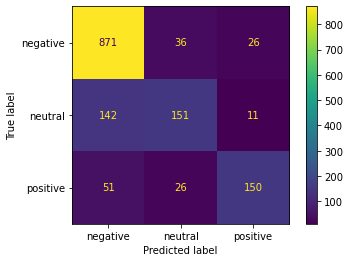

In [40]:
plot_confusion_matrix(model,X_test,y_test) # This is a built in sklearn function


In [41]:
Image(url= "https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg")

In [42]:
# This is from the ROC curve documentation on sklearn and Jose Portilla's DS class notebook
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

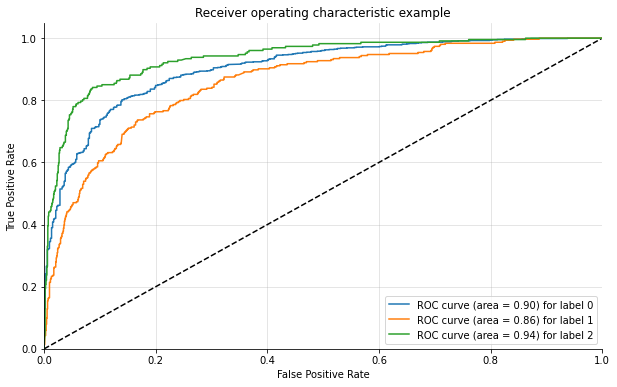

In [43]:
plot_multiclass_roc(model, X_test, y_test, n_classes=3, figsize=(10,6))

In [44]:
#Colors: green: negative, blue: positive, orange: neutral

In [45]:
# PIPELINE

In [46]:
# Set up pipeline so that can take in a tweet directly for predictions
from sklearn.pipeline import Pipeline
pipe = Pipeline([('tfidf',TfidfVectorizer(stop_words='english')),('model',LogisticRegression(max_iter=1000))])
pipe.fit(df['text_cleaned'],df['airline_sentiment'])

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('model', LogisticRegression(max_iter=1000))])

In [47]:
test_pos_tweet = ['This was a great flight. All compliments to the staff!']
test_neutral_tweet = ['The flight was ok overall. Nothing special.']
test_neg_tweet = ['Flight was delayed and had to wait several hours before departure. Horrible experience!']

print(pipe.predict(test_pos_tweet), pipe.predict(test_neutral_tweet), pipe.predict(test_neg_tweet))

['positive'] ['neutral'] ['negative']
